# <center>CMSC320 Final Project - The Musk Effect</center>

<center>Michael Reeve and Sambit Sahoo</center>

## Introduction

In the age of social media and industry, Elon Musk has had a significant impact on our society. Unlike most CEOs, Elon Musk embodies a more millennial style and has a large social media presence. His Twitter account, @elonmusk, has over 120 million followers. Does Elon Musk’s tweets mainly have a positive, negative, or neutral connotation? We will take a closer look a dataset we found on Kaggle, data from our own datascraping, and see the effect of Elon Musk’s tweets.

There are two specific timeframes we would like to investigate thoroughly. On April 4th, 2022, Elon Musk disclosed his stake in Twitter and Twitter announced that he would be joining the board of directors. During this time, did Elon Musk have a positive connotations with his tweets? The second timeframe around October 28th, 2022. Elon Musk announced that he has finalized a deal to acquire Twitter and begin internal processes that lead to strife within the company due to layoffs and other reasons.

This tutorial will guide you through the analysis of Elon Musk’s Twitter data and we will investigate to answer two key questions:
- tmp
- tmp2

In [1]:
# imports
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date as dt, timedelta
import string
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download([
"names",
"stopwords",
"state_union",
"twitter_samples",
"movie_reviews",
"averaged_perceptron_tagger",
"vader_lexicon",
"punkt",
], quiet=True)
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

## Data Collection

For data collection, we decided to combine two methods. First, we found a dataset on Kaggle containing Elon Musk’s tweets from January 27th, 2022 to October 27th, 2022. Additionally, we datascraped data using Twitter’s API to get data from October 20th, 2022 to December 11th, 2022. We noticed that the tweets from October 20th, 2022 to October 27th, 2022 from the Kaggle dataset had fewer likes and retweets mainly because of the time the data was pulled, so it hasn’t updated to the amount of likes and retweets his tweets currently have. The likes and retweets are much higher now than presented in the dataset, so we removed that data and used our datascraped information to replace it. Now, we have a dataset containing tweets from our datascraping from October 20th, 2022 to December 11th, 2022 and tweets from Kaggle, spanning from January 27th, 2022 to October 19th, 2022.

The data collected from datascraping contained information regarding the unfiltered tweet, the date and time the tweet was created, the number of likes, and the number of retweets. The data collected from the Kaggle dataset included the unfiltered tweets, the number of retweets, the number of likes, the date and time of the tweet, and the cleaned tweet.


In [2]:
kaggle_df = pd.read_csv("cleandata.csv")
kaggle_df

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27 16:17:39,thanks
1,@ZubyMusic Absolutely,755,26737,2022-10-27 13:19:25,Absolutely
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers
3,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!
4,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!
...,...,...,...,...,...
2663,@LimitingThe @baglino Just that manganese is a...,171,3173,2022-01-27 22:01:06,Just that manganese is an alternative to iron ...
2664,@incentives101 @ICRicardoLara Exactly,145,4234,2022-01-27 21:23:20,Exactly
2665,@ICRicardoLara Your policies are directly resp...,421,6144,2022-01-27 21:13:57,Your policies are directly responsible for the...
2666,@ICRicardoLara You should be voted out of office,484,7029,2022-01-27 21:12:27,You should be voted out of office


This dataset contains 4 columns, raw text (Tweets), Retweets, Likes, Date, and Cleaned Tweets. The date entries contain time of day and we only care about the date, lets strip the time from these entries.

In [3]:
kaggle_df["Date"] = pd.to_datetime(kaggle_df["Date"]).dt.date
kaggle_df.head()

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27,thanks
1,@ZubyMusic Absolutely,755,26737,2022-10-27,Absolutely
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27,Dear Twitter Advertisers
3,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26,Meeting a lot of cool people at Twitter today!
4,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26,Entering Twitter HQ – let that sink in!


In [4]:
print(kaggle_df["Date"].min(), kaggle_df["Date"].max())

2022-01-27 2022-10-27


This dataset only contains tweets from 1/27-10/27. Let's use the Twitter API to pull tweets after 10/27 through today to add more data to analyze.

The Kaggle dataset was compiled on 10/27, meaning the like and rewteet counts are likely lower than what they would be today. We are assuming that most tweets approach a limit of likes and retweets after about a week of being posted. We are going to gather tweets from 10/20 onward and replace entries in the Kaggle dataset that overlap.

In [5]:
load_dotenv(".env")
token = os.environ.get("BEARER_TOKEN")
headers = {"Authorization": "Bearer {}".format(token)}

ELON_ID = "44196397"

search_url = "https://api.twitter.com/2/users/{}/tweets".format(ELON_ID)

query_params = {
    'start_time': '2022-10-20T00:00:00Z', # Look at tweets after 10/20/22
    'tweet.fields': 'text,created_at,public_metrics', # Retreive text of tweet, date posted, metrics(likes, retweets)
    'max_results': 100, # get 100 tweets every request (this is the max Twitter allows)
}

api_df = pd.DataFrame()

# because we cannot download all tweets at once, we will continue making requests using a technique called pagination (link me)
next_token = ""
while next_token is not None:
    curr_params = query_params.copy()
    if next_token != "":
        curr_params['pagination_token'] = next_token

    # make request to twitter api
    res = requests.request("GET", search_url, headers = headers, params = curr_params)
    res_json = res.json()

    # end of loop check - more on this below
    if 'data' not in res_json:
        next_token = None
        continue
    
    # remove fields Twitter gives back to us that we don't need and de-construct metrics dict
    tweets = res_json['data']
    for t in tweets:
        if 'edit_history_tweet_ids' in t:
            del t['edit_history_tweet_ids']
        if 'id' in t:
            del t['id']
        if 'public_metrics' in t:
            metrics = t['public_metrics']
            t['likes'] = metrics['like_count']
            t['retweets'] = metrics['retweet_count']
            del t['public_metrics']

    # create dataframe out of current 100 tweets then add to cumulative df
    curr_df = pd.DataFrame().from_dict(tweets)
    api_df = pd.concat([api_df, curr_df])

    # check if the next page exists, if not we end the loop by setting next_token to None
    if 'meta' in res_json:
        if 'next_token' in res_json['meta']:
            next_token = res_json['meta']['next_token']
        else:
            next_token = None
    else:
        next_token = None

print(len(api_df), "Tweets")
api_df.head()

1502 Tweets


,created_at,text,likes,retweets
0,2022-12-12T21:40:20.000Z,@BillyM2k Haha totally. High quality bots are ...,1165,81
1,2022-12-12T21:36:52.000Z,@thevivafrei A major fight broke out in the au...,5187,441
2,2022-12-12T21:34:51.000Z,@rupasubramanya @TheFP Exactly,2236,191
3,2022-12-12T21:14:47.000Z,@TRHLofficial @ggreenwald Indeed,2931,202
4,2022-12-12T20:56:45.000Z,@micsolana The wording is mine lol,13557,589


In [6]:
#confirm tweets from the proper date range were retrieved
print("Min:", api_df["created_at"].min(), "  Max:", api_df["created_at"].max()) 

Min: 2022-10-20T00:10:14.000Z   Max: 2022-12-12T21:40:20.000Z


The Twitter API also pulls retweets from the given user, they are defined as the text starting with "RT @" and having 0 likes, lets see how many there are.

In [7]:
api_df[(api_df["text"].apply(lambda x: str(x).startswith("RT @"))) & (api_df["likes"] == 0)]

,created_at,text,likes,retweets
58,2022-12-11T08:27:27.000Z,RT @SpaceX: Deployment of ispace’s HAKUTO-R Mi...,0,3363
64,2022-12-11T07:56:19.000Z,RT @SpaceX: Watch Falcon 9 launch ispace’s HAK...,0,3287
65,2022-12-11T07:56:16.000Z,RT @SpaceX: Falcon 9’s first stage has landed ...,0,3062
66,2022-12-11T07:56:14.000Z,RT @SpaceX: Liftoff! https://t.co/FEenmAJmOz,0,4858
70,2022-12-11T01:45:21.000Z,"RT @CommunityNotes: Beginning today, Community...",0,4390
...,...,...,...,...
60,2022-10-21T21:46:05.000Z,RT @Tesla: Vote for new Supercharger locations...,0,2294
61,2022-10-21T21:45:15.000Z,"RT @Tesla: Our most advanced paint system yet,...",0,1527
71,2022-10-21T06:01:32.000Z,RT @Tesla: https://t.co/CqbkkORG70,0,2656
95,2022-10-20T16:05:22.000Z,RT @SpaceX: Deployment of 54 Starlink satellit...,0,2147


Let's remove those.

In [8]:
api_df = api_df[~((api_df["text"].apply(lambda x: str(x).startswith("RT @"))) & (api_df["likes"] == 0))]
api_df

,created_at,text,likes,retweets
0,2022-12-12T21:40:20.000Z,@BillyM2k Haha totally. High quality bots are ...,1165,81
1,2022-12-12T21:36:52.000Z,@thevivafrei A major fight broke out in the au...,5187,441
2,2022-12-12T21:34:51.000Z,@rupasubramanya @TheFP Exactly,2236,191
3,2022-12-12T21:14:47.000Z,@TRHLofficial @ggreenwald Indeed,2931,202
4,2022-12-12T20:56:45.000Z,@micsolana The wording is mine lol,13557,589
...,...,...,...,...
99,2022-10-20T07:57:25.000Z,@marenkahnert @jasondebolt Exactly,1932,79
0,2022-10-20T07:30:52.000Z,@Teslarati @13ericralph31 SpaceX has more acti...,16141,1390
1,2022-10-20T06:52:01.000Z,@jasondebolt The media reports with great fanf...,23012,1492
2,2022-10-20T06:38:51.000Z,@jakebrowatzke @andyjayhawk 🤣,1949,78


The ```created_at``` column contains the date and time a tweet was created. We only care about the date so let's strip the date and time down to date, then rename the column to "date"

In [9]:
api_df["date"] = pd.to_datetime(api_df["created_at"]).dt.date
api_df = api_df.drop(columns="created_at")
api_df.head()

,text,likes,retweets,date
0,@BillyM2k Haha totally. High quality bots are ...,1165,81,2022-12-12
1,@thevivafrei A major fight broke out in the au...,5187,441,2022-12-12
2,@rupasubramanya @TheFP Exactly,2236,191,2022-12-12
3,@TRHLofficial @ggreenwald Indeed,2931,202,2022-12-12
4,@micsolana The wording is mine lol,13557,589,2022-12-12


Now lets combine the two datasets

First step is to remove entries after 10/19 from the Kaggle dataset, these will be replaced by the Twitter API dataset.

In [10]:
kaggle_df = kaggle_df[~(kaggle_df["Date"] > dt(2022,10,19))]
kaggle_df

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
95,@westcoastbill Will require truly exceptional ...,745,11060,2022-10-19,"Will require truly exceptional execution, but ..."
96,"I will not let you down, no matter what it takes",35111,392237,2022-10-19,"I will not let you down, no matter what it takes"
97,@DirtyTesLa Awesome,88,2381,2022-10-19,Awesome
98,We even did a Starlink video call on one airpl...,2060,37029,2022-10-19,We even did a Starlink video call on one airpl...
99,Vox Populi Vox Dei,5709,53880,2022-10-19,Vox Populi Vox Dei
...,...,...,...,...,...
2663,@LimitingThe @baglino Just that manganese is a...,171,3173,2022-01-27,Just that manganese is an alternative to iron ...
2664,@incentives101 @ICRicardoLara Exactly,145,4234,2022-01-27,Exactly
2665,@ICRicardoLara Your policies are directly resp...,421,6144,2022-01-27,Your policies are directly responsible for the...
2666,@ICRicardoLara You should be voted out of office,484,7029,2022-01-27,You should be voted out of office


Then we need to rename and reorder the columns so that they match the Twitter API datset, as well as drop the `Cleaned_Tweets` column in the Kaggle dataset (we will implement our own cleaning later).

In [11]:
tmp_kaggle_df = kaggle_df.drop(columns="Cleaned_Tweets")
tmp_kaggle_df.columns = ["text", "retweets", "likes", "date"]

tmp_kaggle_df = tmp_kaggle_df[["text", "date", "likes", "retweets"]]

df = pd.concat([api_df,tmp_kaggle_df])
df

,text,likes,retweets,date
0,@BillyM2k Haha totally. High quality bots are ...,1165,81,2022-12-12
1,@thevivafrei A major fight broke out in the au...,5187,441,2022-12-12
2,@rupasubramanya @TheFP Exactly,2236,191,2022-12-12
3,@TRHLofficial @ggreenwald Indeed,2931,202,2022-12-12
4,@micsolana The wording is mine lol,13557,589,2022-12-12
...,...,...,...,...
2663,@LimitingThe @baglino Just that manganese is a...,3173,171,2022-01-27
2664,@incentives101 @ICRicardoLara Exactly,4234,145,2022-01-27
2665,@ICRicardoLara Your policies are directly resp...,6144,421,2022-01-27
2666,@ICRicardoLara You should be voted out of office,7029,484,2022-01-27


In [12]:
# confirm date range is 1/27 - today
print("Min:", df["date"].min(), "  Max:", df["date"].max())

Min: 2022-01-27   Max: 2022-12-12


We now have a combined dataset that we can start to use in our analysis!

## Data Cleaning

For the data obtained from both methods, we only need to keep the date of the tweet for future analysis, removing the time of the tweet. The amount of likes and retweets remained untouched. We got rid of the cleaned tweet from the Kaggle dataset since we will use our own cleaner on the original tweet. In the tweets obtained from Twitter’s API, it includes retweets, which we don’t need. We removed the 72 instances of retweets.
 
Now, we can combine the two datasets in one dataframe. We looked at the contents of the tweets. In each tweet, it may include mentions of other users, indicated by @ followed by a username (e.g. “@cmsc320”, “@maxiscool”), links to other tweets, websites, and media like images or videos. We need to remove that from the text field.    


In [13]:
df["cleaned_text"] = df["text"].apply(lambda x: re.sub(r'@\w+', "", x))
df["cleaned_text"] = df["cleaned_text"].apply(lambda x: re.sub(r'https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)', "", x))
df["cleaned_text"] = df["cleaned_text"].apply(lambda x: x.replace("&amp;", "&"))
df.head()

,text,likes,retweets,date,cleaned_text
0,@BillyM2k Haha totally. High quality bots are ...,1165,81,2022-12-12,Haha totally. High quality bots are fine!
1,@thevivafrei A major fight broke out in the au...,5187,441,2022-12-12,A major fight broke out in the audience just ...
2,@rupasubramanya @TheFP Exactly,2236,191,2022-12-12,Exactly
3,@TRHLofficial @ggreenwald Indeed,2931,202,2022-12-12,Indeed
4,@micsolana The wording is mine lol,13557,589,2022-12-12,The wording is mine lol


## Exploratory Data Analysis

Did Elon Tweet every day from 1/27 until today? In order to find out, we need to find the difference in every day in that range and the unique values from the date column. This will be helpful later when we plot data.

In [14]:
min_date = df["date"].min()
max_date = df["date"].max()
time_delta = max_date - min_date

all_dates = [min_date + timedelta(x) for x in range(time_delta.days + 1)]
all_dates

diff_in_dates = set(all_dates) - set(df["date"].unique().tolist())
print(len(diff_in_dates))
diff_in_dates

23


{datetime.date(2022, 2, 24),
 datetime.date(2022, 2, 27),
 datetime.date(2022, 3, 23),
 datetime.date(2022, 4, 11),
 datetime.date(2022, 4, 12),
 datetime.date(2022, 4, 13),
 datetime.date(2022, 5, 5),
 datetime.date(2022, 6, 22),
 datetime.date(2022, 6, 23),
 datetime.date(2022, 6, 24),
 datetime.date(2022, 6, 25),
 datetime.date(2022, 6, 26),
 datetime.date(2022, 6, 27),
 datetime.date(2022, 6, 28),
 datetime.date(2022, 6, 29),
 datetime.date(2022, 6, 30),
 datetime.date(2022, 7, 1),
 datetime.date(2022, 7, 3),
 datetime.date(2022, 7, 9),
 datetime.date(2022, 7, 10),
 datetime.date(2022, 7, 17),
 datetime.date(2022, 8, 3),
 datetime.date(2022, 9, 2)}

Looks like Elon did not tweet on 23 days. He took a 9 day break from June 22th to June 30th, 2022.

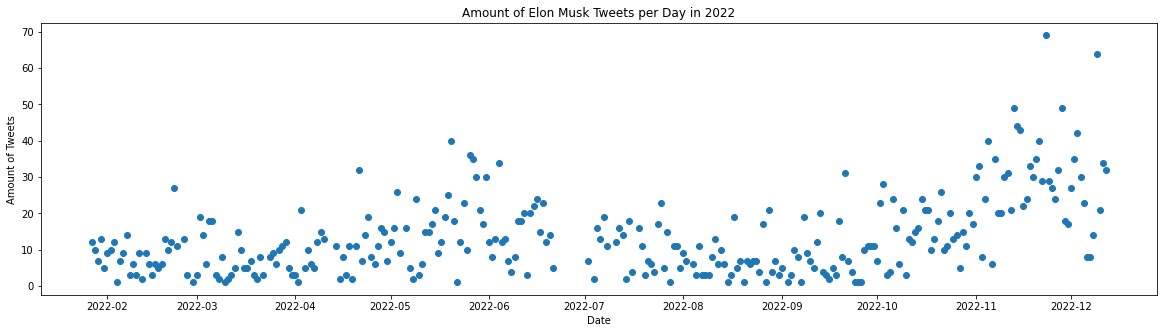

In [15]:
dates_count_group = df.groupby(by="date", as_index=False).count()

plt.figure(figsize=(20,5))
plt.scatter(dates_count_group["date"], dates_count_group["text"])
plt.title("Amount of Elon Musk Tweets per Day in 2022")
plt.xlabel("Date")
plt.ylabel("Amount of Tweets")
plt.show()

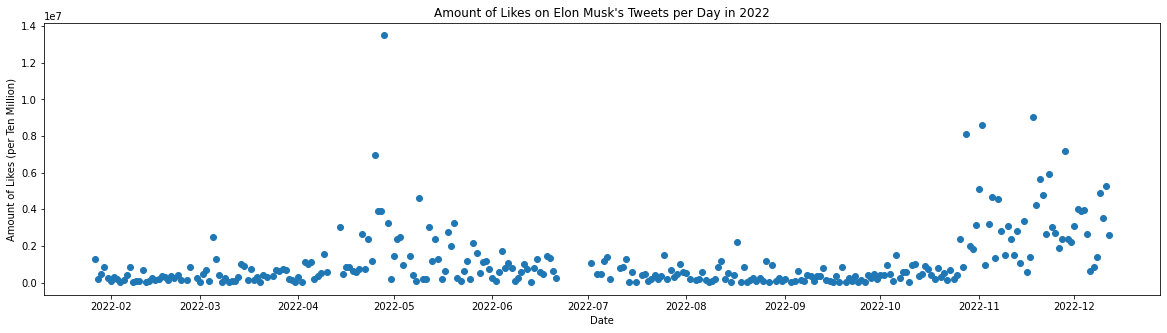

In [16]:
dates_sum_group = df.groupby(by="date", as_index=False).sum()

plt.figure(figsize=(20,5))
plt.scatter(dates_sum_group["date"], dates_sum_group["likes"])
plt.title("Amount of Likes on Elon Musk's Tweets per Day in 2022")
plt.xlabel("Date")
plt.ylabel("Amount of Likes (per Ten Million)")
plt.show()

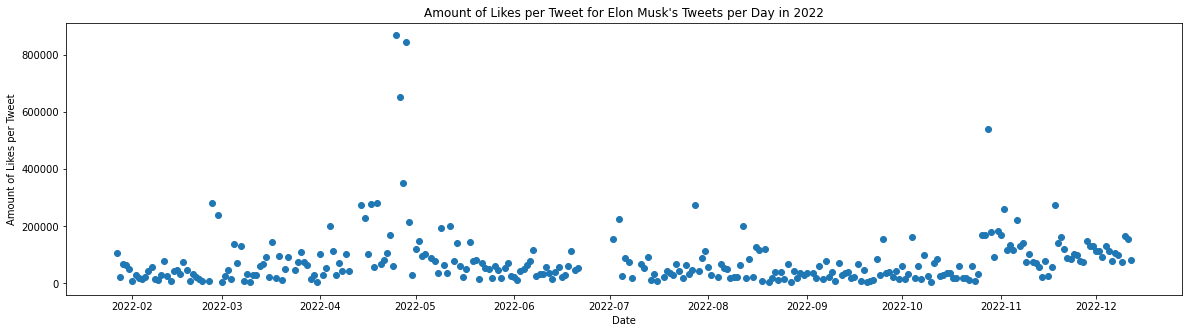

In [17]:
df_likes_to_tweets = dates_sum_group.copy()
df_likes_to_tweets["text"] = dates_count_group["text"]
df_likes_to_tweets["likes/tweets"] = df_likes_to_tweets.apply(lambda x: x["likes"]/x["text"], axis=1)


plt.figure(figsize=(20,5))
plt.scatter(df_likes_to_tweets["date"], df_likes_to_tweets["likes/tweets"])
plt.title("Amount of Likes per Tweet for Elon Musk's Tweets per Day in 2022")
plt.xlabel("Date")
plt.ylabel("Amount of Likes per Tweet")
plt.show()

In [18]:
# 4/28 is the date of his most liked tweet (i think) - remove me later
df[df["date"] == dt(2022, 4, 28)]

,text,likes,retweets,date,cleaned_text
1935,“Real magic is only a sip away.”\n(Actual slog...,425103,20786,2022-04-28,“Real magic is only a sip away.”\n(Actual slog...
1936,.@CocaCola Oh hi lol https://t.co/VhhVM9GzLJ,625037,42793,2022-04-28,. Oh hi lol
1937,@BillyM2k Same,64418,1497,2022-04-28,Same
1938,@walterkirn Freedom of speech means freedom of...,271336,20619,2022-04-28,Freedom of speech means freedom of speech
1939,@scrowder Discomforting,66614,4285,2022-04-28,Discomforting
1940,@DavidSacks @willcain Accurate interview,27234,1254,2022-04-28,Accurate interview
1941,@WatcherGuru FCC FTW!,64698,3419,2022-04-28,FCC FTW!
1942,@pmarca Sounds like satire,37765,1720,2022-04-28,Sounds like satire
1943,@DrRamblings @BillyM2k Great show!,15196,323,2022-04-28,Great show!
1944,@dogeofficialceo Trumpet is legit a way better...,69642,2209,2022-04-28,Trumpet is legit a way better name


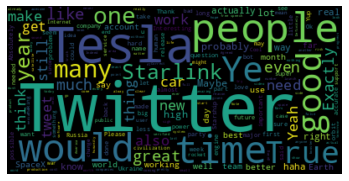

In [19]:
# create stopword list & wordcloud:
stops = set(stopwords.words('english') + list(string.punctuation))
stops.add("amp")
stops.add("…")
stops.add("’")
stops.add("“")
stops.add("”")
textt = " ".join(tweet for tweet in df["cleaned_text"])
wordcloud = WordCloud(stopwords=stops).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
all_tweets = df["cleaned_text"].str.cat(sep=" ").strip()
words: list[str] = [w for w in nltk.word_tokenize(all_tweets) if w not in stops]
fd = nltk.FreqDist(words)
fd.most_common(10)

finder = nltk.collocations.TrigramCollocationFinder.from_words(words)
finder.ngram_fd.most_common(10)

[(('woke', 'mind', 'virus'), 6),
 (('make', 'life', 'multiplanetary'), 6),
 (('Tesla', 'AI', 'Day'), 6),
 (('The', 'New', 'York'), 5),
 (('New', 'York', 'Times'), 5),
 (('result', 'account', 'suspension'), 5),
 (('needed', 'make', 'life'), 4),
 (('The', 'Twitter', 'Files'), 4),
 (('I', 'think', 'I'), 4),
 (('free', 'speech', 'America'), 4)]

In [21]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

scores = df["cleaned_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

df["neg"] = scores.apply(lambda x: 1 if x < -0.05 else 0)
df["neu"] = scores.apply(lambda x: 1 if x >= -0.05 and x <= 0.05 else 0)
df["pos"] = scores.apply(lambda x: 1 if x > 0.05 else 0)

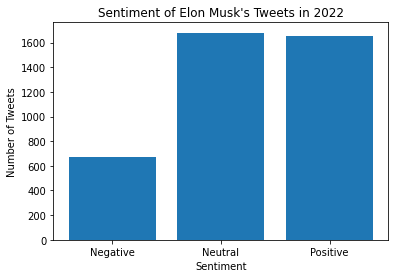

In [22]:
values = [df["neg"].sum(), df["neu"].sum(), df["pos"].sum()]
plt.bar(x=["Negative", "Neutral", "Positive"], height=values)
plt.title("Sentiment of Elon Musk's Tweets in 2022")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()

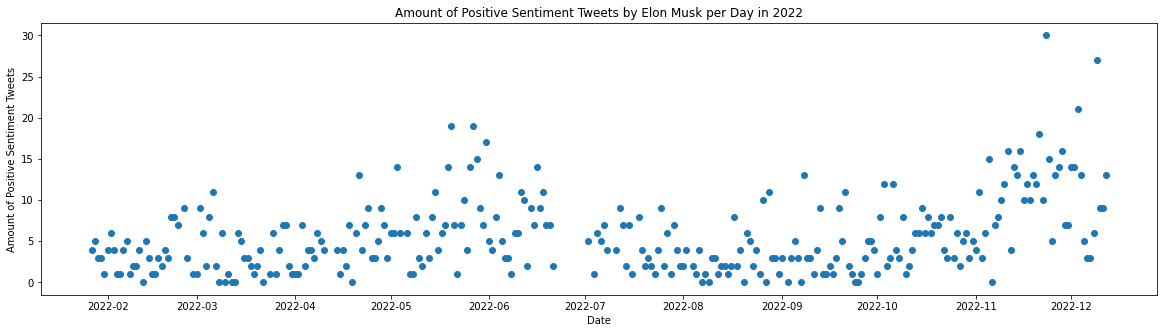

In [23]:
pos_date_group = df.groupby(by="date", as_index=False).sum()
plt.figure(figsize=(20,5))
plt.scatter(x=pos_date_group["date"], y=pos_date_group["pos"])
plt.title("Amount of Positive Sentiment Tweets by Elon Musk per Day in 2022")
plt.xlabel("Date")
plt.ylabel("Amount of Positive Sentiment Tweets")
plt.show()

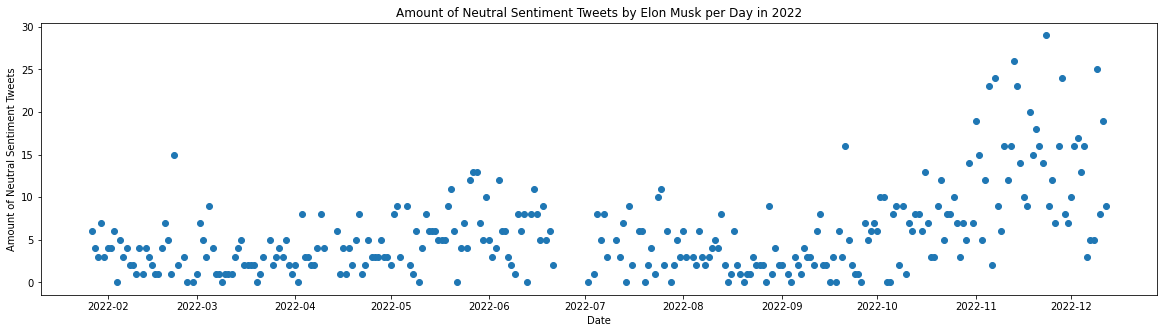

In [24]:
pos_date_group = df.groupby(by="date", as_index=False).sum()
plt.figure(figsize=(20,5))
plt.scatter(x=pos_date_group["date"], y=pos_date_group["neu"])
plt.title("Amount of Neutral Sentiment Tweets by Elon Musk per Day in 2022")
plt.xlabel("Date")
plt.ylabel("Amount of Neutral Sentiment Tweets")
plt.show()

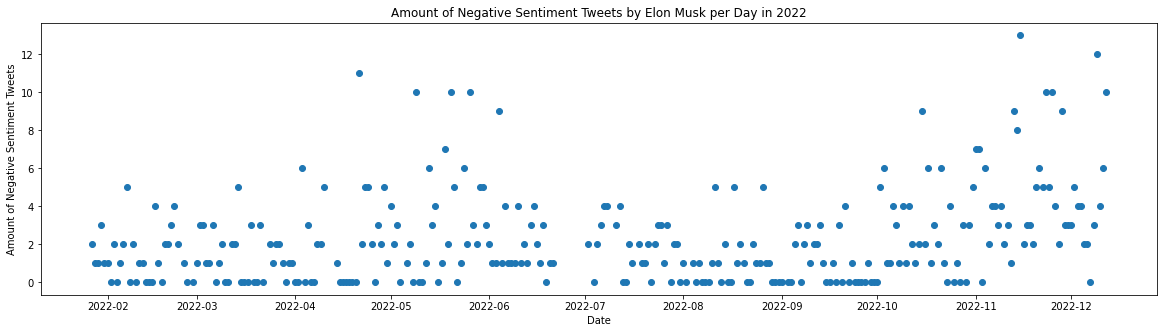

In [25]:
pos_date_group = df.groupby(by="date", as_index=False).sum()
plt.figure(figsize=(20,5))
plt.scatter(x=pos_date_group["date"], y=pos_date_group["neg"])
plt.title("Amount of Negative Sentiment Tweets by Elon Musk per Day in 2022")
plt.xlabel("Date")
plt.ylabel("Amount of Negative Sentiment Tweets")
plt.show()